## Purpose:
The goal of this project is to use ensemble learners to generate predictions. 

## Pre-processing

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display
import numpy as np
import pandas as pd
import seaborn as sns; sns.set(style="ticks", color_codes=True)

# Load data file and print data head to check proper loading
df = pd.read_csv('Datasets/heart_dataset.csv')
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [2]:
print(f'Number of rows: {df.shape[0]}')

Number of rows: 918


In [3]:
# Check for duplicates, this adds a new column to the dataset
df["is_duplicate"]= df.duplicated()

print(f"Training data size = {len(df)}")
print(f"Duplicates in TRAINING data = {len(df[df['is_duplicate']==True])}")

Training data size = 918
Duplicates in TRAINING data = 0


In [4]:
# Drop the duplicate rows using index
index_to_drop = df[df['is_duplicate']==True].index
df.drop(index_to_drop, inplace=True)

# Remove the duplicate marker column
df.drop(columns='is_duplicate', inplace=True)
print(f'Training count = {len(df)}')

Training count = 918


In [5]:
# Do we have NaN in our dataset?
df.isnull().any()

Age               False
Sex               False
ChestPainType     False
RestingBP         False
Cholesterol       False
FastingBS         False
RestingECG        False
MaxHR             False
ExerciseAngina    False
Oldpeak           False
ST_Slope          False
HeartDisease      False
dtype: bool

In [6]:
# Check unique levels and see any marker is used or left out for a missing level
for col in df.columns:
    if df[col].dtype == object:
        print (col, df[col].unique())

Sex ['M' 'F']
ChestPainType ['ATA' 'NAP' 'ASY' 'TA']
RestingECG ['Normal' 'ST' 'LVH']
ExerciseAngina ['N' 'Y']
ST_Slope ['Up' 'Flat' 'Down']


In [7]:
# One-hot encoder to convert nominal features into numerical values
def encode_onehot(_df, _f):
    _df2 = pd.get_dummies(_df[_f], prefix='', prefix_sep='').groupby(level=0, axis=1).max().add_prefix(_f+' - ')
    _df3 = pd.concat([_df, _df2], axis=1)
    _df3 = _df3.drop([_f], axis=1)
    return _df3

In [8]:
# One hot encode nominal features
df_o = encode_onehot(df, 'Sex')
df_o = encode_onehot(df_o, 'ChestPainType')
df_o = encode_onehot(df_o, 'RestingECG')
df_o = encode_onehot(df_o, 'ExerciseAngina')
df_o = encode_onehot(df_o, 'ST_Slope')

In [9]:
# Check one hot encoding
df_o = df_o.astype(float)
df_o.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex - F,Sex - M,ChestPainType - ASY,...,ChestPainType - NAP,ChestPainType - TA,RestingECG - LVH,RestingECG - Normal,RestingECG - ST,ExerciseAngina - N,ExerciseAngina - Y,ST_Slope - Down,ST_Slope - Flat,ST_Slope - Up
0,40.0,140.0,289.0,0.0,172.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1,49.0,160.0,180.0,0.0,156.0,1.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
2,37.0,130.0,283.0,0.0,98.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3,48.0,138.0,214.0,0.0,108.0,1.5,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
4,54.0,150.0,195.0,0.0,122.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


In [10]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

# 10-fold CV evaluation of a classifier
def eval_classifier(_clf, _X, _y):
    accuracies = []
    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
    for train_index, test_index in kf.split(_X, _y):
        _clf.fit(_X[train_index], _y[train_index])
        y_pred = _clf.predict(_X[test_index])
        accuracies += [accuracy_score(_y[test_index], y_pred)]
    return np.array(accuracies)

In [11]:
# Product datasets containing independent variables and dependent variable
X = df_o.loc[:, df_o.columns != 'HeartDisease'].values
y = df_o.loc[:, df_o.columns == 'HeartDisease'].values.ravel()

### Naive Bayes

In [12]:
from sklearn.naive_bayes import GaussianNB

acc = eval_classifier(GaussianNB(),
                      X, y)
print(f'Naive Bayes CV accuracy={np.mean(acc):.2f} {chr(177)}{np.std(acc):.3f}')

Naive Bayes CV accuracy=0.86 ±0.034


### SVC - Linear

In [13]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

svm_linear = make_pipeline(StandardScaler(), 
                           SVC(kernel='linear', probability=True))

acc = eval_classifier(svm_linear,
                      X, y)
print(f'Linear SVC CV accuracy={np.mean(acc):.2f} {chr(177)}{np.std(acc):.3f}')

Linear SVC CV accuracy=0.86 ±0.030


### Neural Network - MLP Classifier

In [14]:
from sklearn.neural_network import MLPClassifier

acc = eval_classifier(MLPClassifier(hidden_layer_sizes=(50,100),max_iter=500),
                      X, y)
print(f'Neural Network CV accuracy={np.mean(acc):.2f} {chr(177)}{np.std(acc):.3f}')

Neural Network CV accuracy=0.82 ±0.048


### Decision Tree Classifier

In [15]:
from sklearn.tree import DecisionTreeClassifier

acc = eval_classifier(DecisionTreeClassifier(),
                      X, y)
print(f'Decision Tree CV accuracy={np.mean(acc):.2f} {chr(177)}{np.std(acc):.3f}')

Decision Tree CV accuracy=0.79 ±0.045


### Random Forest

In [16]:
from sklearn.ensemble import RandomForestClassifier

acc = eval_classifier(RandomForestClassifier(n_estimators=200, max_depth=5, random_state=0, n_jobs=4),
                      X, y)
print(f'Random Forest CV accuracy={np.mean(acc):.2f} {chr(177)}{np.std(acc):.3f}')

Random Forest CV accuracy=0.88 ±0.039


# Question 2

In [17]:
# Helper arrays to be used for looping through each classifier
classifiers = [GaussianNB(), svm_linear, 
               MLPClassifier(hidden_layer_sizes=(5, 5),max_iter=30, tol=1e-1), DecisionTreeClassifier(max_depth = 5, max_features = 5)]
clf_names = ["Naive Bayes", "SVM Linear", "MLP Classifier", "DecisionTree"]

In [18]:
from sklearn.model_selection import train_test_split
import copy

# Generates 100 unique classifiers and returns the array containing them
def runner(_clf, _niters):
    return [copy.deepcopy(_clf) for _ in range(_niters)]

In [20]:
from sklearn.model_selection import train_test_split
import warnings

# Generates 100 classifiers for each classifer in Question 1. It then prints out the accuracy of the
# first classifier in the ensemble. 
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for counter in range(len(clf_names)):
        ensemble_array = runner(classifiers[counter], 100)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)
        temp_clf = ensemble_array[0].fit(X_train, y_train)
        y_pred = temp_clf.predict(X_test)
        acc = [accuracy_score(y_test, y_pred)]
    
        print(f'{clf_names[counter]} Ensemble - first classifier accuracy = {acc[0]:.3f} ')    

Naive Bayes Ensemble - first classifier accuracy = 0.902 
SVM Linear Ensemble - first classifier accuracy = 0.908 
MLP Classifier Ensemble - first classifier accuracy = 0.576 
DecisionTree Ensemble - first classifier accuracy = 0.826 


## Question 3

In [21]:
import math 
import random

# Input - _ensemble_array is the array containing multiple copies of a single classifier
# Input - _subsample is a float value for subsample training data sizes
# This method will fit all iterations of an ensemble with a subset of random values from the training
# data set. It will then return an array containing the fitted classifiers obtained from above.
def ensemble_fit(_ensemble_array, _X, _y, _subsample):
    clf_fitted = []    
    for counter in range(len(_ensemble_array)):
        X_train, X_test, y_train, y_test = train_test_split(_X, _y, 
                                                            train_size=_subsample, 
                                                            stratify = _y, 
                                                            random_state=counter)
        trained_clf = _ensemble_array[counter].fit(X_train, y_train) 
        clf_fitted.append(trained_clf)
    return clf_fitted

## Question 4

In [22]:
from statistics import mode

# Input - _fit_ensemble_array is the array of classifiers that have been fitted with training data
# This method will take an ensemble containing fitted classifiers and use it to compute the predicted
# outputs for a dataset. It will then return the array of predictions. 
def ensemble_predict(_fit_ensemble_array, _X):   
    y_pred_ensemble, y_prob_ensemble = [], []     
    
    for counter in range(len(_fit_ensemble_array)):
        y_pred_temp = _fit_ensemble_array[counter].predict(_X)
        y_pred_ensemble.append(y_pred_temp)  
    y_pred = []  
    for counter2 in range(len(_X)):
        y_pred_temp = map(lambda x: x[counter2], y_pred_ensemble)
        final_value = mode(y_pred_temp)
        y_pred.append(final_value)
        
    return y_pred

## Question 5

In [23]:
# Method that will evaluate the accuracy of an ensemble classifier. It will generate an array of 
# accuracies for the ensemble and return it. 
def ensemble_evaluate(_clf, _X, _y, _niters, _subsample):
    accuracies = []
    clf_arrays =  runner(_clf, _niters)
    
    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
    for train_index, test_index in kf.split(_X, _y):        
        fitted_ensemble = ensemble_fit(clf_arrays, _X[train_index], _y[train_index], _subsample)       
        y_pred = ensemble_predict(fitted_ensemble, _X[test_index])                   
        accuracies += [accuracy_score(_y[test_index], y_pred)]                
    return np.array(accuracies)

In [24]:
subsample_array = [0.2, 0.05]

# Prints out the accuracy and standard deviation of running an ensemble classifier using Naive-Bayes and
# DecisionTreeClassifier. It compares the two against one another with the sub-sample sizes 0.2 and 0.05.
# Comprehensive breakdown of each classifier is presented in the next question.
for count in range(len(subsample_array)):
    acc = ensemble_evaluate(GaussianNB(), X, y, 100, subsample_array[count])
    print(f'Naive Bayes - Subsample {subsample_array[count]} - Acc = {np.mean(acc):.3f} {chr(177)}{np.std(acc):.3f}')
    
for count in range(len(subsample_array)):
    acc = ensemble_evaluate(DecisionTreeClassifier(), X, y, 100, subsample_array[count])
    print(f'Decision Tree - Subsample {subsample_array[count]} - Acc = {np.mean(acc):.3f} {chr(177)}{np.std(acc):.3f}')

Naive Bayes - Subsample 0.2 - Acc = 0.858 ±0.045
Naive Bayes - Subsample 0.05 - Acc = 0.862 ±0.046
Decision Tree - Subsample 0.2 - Acc = 0.870 ±0.038
Decision Tree - Subsample 0.05 - Acc = 0.856 ±0.046


## Question 6

Naive Bayes Ensemble Subsample 0.2 - Acc = 0.858 ±0.045
Naive Bayes Regular Subsample 0.2 - Acc = 0.863 ±0.043

Naive Bayes Ensemble Subsample 0.1 - Acc = 0.857 ±0.048
Naive Bayes Regular Subsample 0.1 - Acc = 0.838 ±0.051

Naive Bayes Ensemble Subsample 0.05 - Acc = 0.862 ±0.046
Naive Bayes Regular Subsample 0.05 - Acc = 0.838 ±0.057

Naive Bayes Ensemble Subsample 0.03 - Acc = 0.865 ±0.047
Naive Bayes Regular Subsample 0.03 - Acc = 0.783 ±0.044

Naive Bayes Ensemble Subsample 0.01 - Acc = 0.862 ±0.041
Naive Bayes Regular Subsample 0.01 - Acc = 0.761 ±0.119

Naive Bayes Ensemble Subsample 0.005 - Acc = 0.840 ±0.035
Naive Bayes Regular Subsample 0.005 - Acc = 0.651 ±0.154



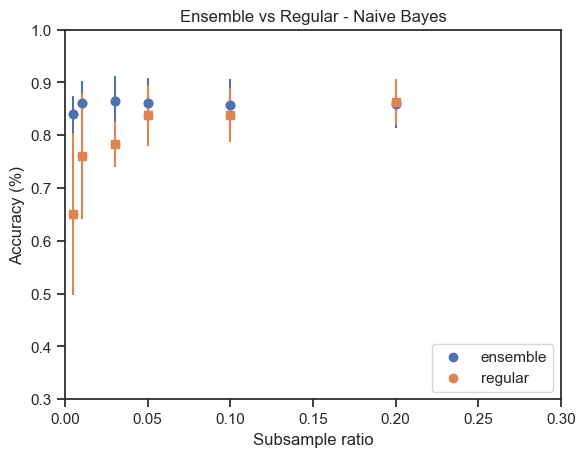

SVM Linear Ensemble Subsample 0.2 - Acc = 0.864 ±0.048
SVM Linear Regular Subsample 0.2 - Acc = 0.846 ±0.033

SVM Linear Ensemble Subsample 0.1 - Acc = 0.861 ±0.043
SVM Linear Regular Subsample 0.1 - Acc = 0.812 ±0.038

SVM Linear Ensemble Subsample 0.05 - Acc = 0.866 ±0.046
SVM Linear Regular Subsample 0.05 - Acc = 0.783 ±0.027

SVM Linear Ensemble Subsample 0.03 - Acc = 0.860 ±0.051
SVM Linear Regular Subsample 0.03 - Acc = 0.763 ±0.064

SVM Linear Ensemble Subsample 0.01 - Acc = 0.852 ±0.034
SVM Linear Regular Subsample 0.01 - Acc = 0.763 ±0.093

SVM Linear Ensemble Subsample 0.005 - Acc = 0.843 ±0.038
SVM Linear Regular Subsample 0.005 - Acc = 0.738 ±0.100



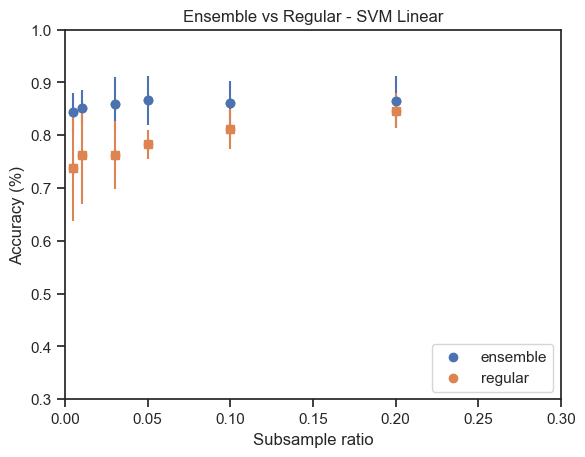

MLP Classifier Ensemble Subsample 0.2 - Acc = 0.617 ±0.068
MLP Classifier Regular Subsample 0.2 - Acc = 0.508 ±0.040

MLP Classifier Ensemble Subsample 0.1 - Acc = 0.551 ±0.075
MLP Classifier Regular Subsample 0.1 - Acc = 0.520 ±0.062

MLP Classifier Ensemble Subsample 0.05 - Acc = 0.580 ±0.059
MLP Classifier Regular Subsample 0.05 - Acc = 0.500 ±0.067

MLP Classifier Ensemble Subsample 0.03 - Acc = 0.573 ±0.062
MLP Classifier Regular Subsample 0.03 - Acc = 0.477 ±0.067

MLP Classifier Ensemble Subsample 0.01 - Acc = 0.538 ±0.066
MLP Classifier Regular Subsample 0.01 - Acc = 0.515 ±0.103

MLP Classifier Ensemble Subsample 0.005 - Acc = 0.492 ±0.059
MLP Classifier Regular Subsample 0.005 - Acc = 0.496 ±0.051



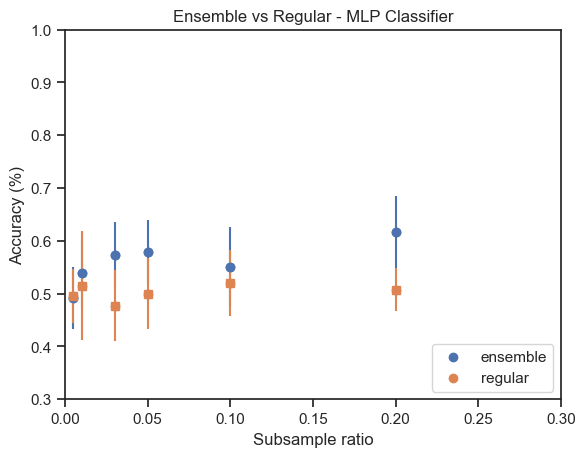

DecisionTree Ensemble Subsample 0.2 - Acc = 0.866 ±0.037
DecisionTree Regular Subsample 0.2 - Acc = 0.795 ±0.044

DecisionTree Ensemble Subsample 0.1 - Acc = 0.869 ±0.040
DecisionTree Regular Subsample 0.1 - Acc = 0.770 ±0.054

DecisionTree Ensemble Subsample 0.05 - Acc = 0.858 ±0.038
DecisionTree Regular Subsample 0.05 - Acc = 0.787 ±0.053

DecisionTree Ensemble Subsample 0.03 - Acc = 0.862 ±0.046
DecisionTree Regular Subsample 0.03 - Acc = 0.763 ±0.050

DecisionTree Ensemble Subsample 0.01 - Acc = 0.839 ±0.041
DecisionTree Regular Subsample 0.01 - Acc = 0.685 ±0.136

DecisionTree Ensemble Subsample 0.005 - Acc = 0.830 ±0.048
DecisionTree Regular Subsample 0.005 - Acc = 0.628 ±0.144



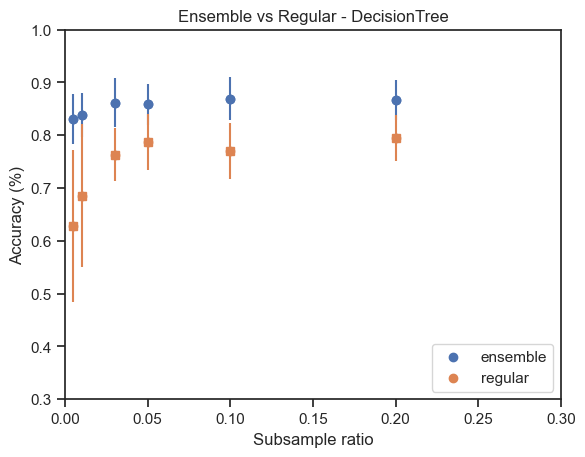

In [25]:
import matplotlib.pyplot as plt

# Helper arrays to iterate through each classifier and sub-set value
classifiers_ensemble = [GaussianNB(), svm_linear, 
               MLPClassifier(hidden_layer_sizes=(5, 5),max_iter=30, tol=1e-1), DecisionTreeClassifier(max_depth = 5, max_features = 5)]
classifiers_regular = [GaussianNB(), svm_linear, 
               MLPClassifier(hidden_layer_sizes=(50,100),max_iter=500), DecisionTreeClassifier()]
clf_names = ["Naive Bayes", "SVM Linear", "MLP Classifier", "DecisionTree"]
subsample_array = [0.2, 0.1, 0.05, 0.03, 0.01, 0.005]


# Calculate and plot the ensemble classifier accuracies and regular classifier accuracies (with standard 
# deviations). 
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for counter1 in range(len(clf_names)):
        accuracies_ensemble = []
        st_dev_ensemble = []
        accuracies_regular = []
        st_dev_regular = []
        
        for counter2 in range(len(subsample_array)):
            temp_acc = ensemble_evaluate(classifiers_ensemble[counter1], X, y, 100, subsample_array[counter2])
            accuracies_ensemble.append(np.mean(temp_acc))
            st_dev_ensemble.append(np.std(temp_acc))
            print(f'{clf_names[counter1]} Ensemble Subsample {subsample_array[counter2]} - Acc = {np.mean(temp_acc):.3f} {chr(177)}{np.std(temp_acc):.3f}')
            
            temp_acc = ensemble_evaluate(classifiers[counter1], X, y, 1, subsample_array[counter2])
            accuracies_regular.append(np.mean(temp_acc))
            st_dev_regular.append(np.std(temp_acc))
            print(f'{clf_names[counter1]} Regular Subsample {subsample_array[counter2]} - Acc = {np.mean(temp_acc):.3f} {chr(177)}{np.std(temp_acc):.3f}\n')
                       
        #Generate scatter plot with standard deviation bars
        plt.scatter(subsample_array, accuracies_ensemble, label='ensemble')
        plt.scatter(subsample_array, accuracies_regular, label='regular')
        plt.xlim(0, 0.3)
        plt.ylim(0.3, 1.0)
        plt.errorbar(subsample_array, accuracies_ensemble, yerr=st_dev_ensemble, fmt="o")
        plt.errorbar(subsample_array, accuracies_regular, yerr=st_dev_regular, fmt="s")
        plt.title(f'Ensemble vs Regular - {clf_names[counter1]}')
        plt.xlabel("Subsample ratio")
        plt.ylabel("Accuracy (%)")
        plt.legend(loc='lower right')
        plt.show()

### Question 6 Discussion

When looking at only the ensemble data, it appears that the best accuracy classifier occurs when the sub-sampling size is not at the extremes. In other words, when the sub-sampling size is between 0.03 – 0.1, the ensemble appears to have the best accuracy. However, this trend of sub-sampling sizes also affects standard deviation. There are lower standard deviations at the extremes, and higher standard deviations in the mid-sizes of sub-sampling. These results would lead me to think that the larger sub-sampling size may result in overfitting while the lower sub-sampling sizes are a result of underfitting. Another observation that I would also note is that the sub-sampling sizes resulted in training sizes of 4-18 dataset values. This variance between training dataset values may also account for this change. Because of the limited sizes, stratification may not necessarily have the same effect between each sub-sample. 

When comparing the ensemble classifiers with the singular, regular classifiers, there is a stark contrast in standard deviations. This is most likely due to the increased number of iterations in the ensemble training. The increased number of iterations helped to reduce variance by increasing counts for each datapoint. The training data had a greater “confidence” with the increased number of data points. In terms of raw accuracy, it appears that all the ensemble classifiers, with exception to the neural network, performed better than its singular, regular classifier counterpart. I believe the difference in the neural network may be a result of the low number of training values available for it to train on. Because of the low number of training values, it was not able to develop a robust network. Another trend to note is that the ensemble classifiers had better performance when compared to their counterparts at lower sub-sample sizes. Similar to the lower standard deviation found in the ensemble classifiers, this is most likely due to the increased number of data points to help the predictions. 

If I were to do this problem again, I would be curious to see the effects of increasing and decreasing the number of features would look like. Secondly, I would also look at varying sizes of datasets. Because of the ensemble neural networks low accuracy values, I am curious if there is a size value where accuracy drastically improves.  
